In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask
from scipy.signal import fftconvolve
import dask.array as da
from pulse_pair_doppler import pulse_pair_doppler
from beam_pattern import azimuth_beamwidth, beam_pattern_oneway

In [2]:
model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=20e-4,                # s 
    t_interpulse=0*1e-4,              # s
    t_decor=3e-3,
    # n_reflectors=4,            # -    TODO why does this number increase error?
    # temporal_decorr = 0.98,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=2,           # -    TODO why does this number increase error?
    range_cell_avg_factor=1,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

model.chirp(centre_around_baseband=True).pulse_pairs()

pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, t_decor=0.003, temporal_coherence=0.998531634660417, n_reflectors=None, oversample_retriev=2, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

## TODO
- find resolution along azimuth
- add 2D beam pattern
- Dask support
- decorrelate surface AND add phase corersponding to added distance between subpulses
- 
- add velocity

In [3]:
c = 3e8
res_az = 150 # m   TODO find resolution along azimuth # horizontal_beamwidth_surface (3db?) * z0 / cos(incidence) eq.14.4 Ulaby
res_rg = 150 # m   TODO make function of bandwith
n_scatterers_per_cell = 1
extent_rg = 600e3 #600e3 # m 
extent_az = 150e3 # m
incidence_min = 29 # deg
x0, y0, z0 = 0, 0, 700e3 # m azimuth, range, altitude satellite
PRF = 5 # / s
distance_satellite = 25e3 # m 
vy_satellite, vx_satellite, vz_satellite = 0, 6800, 0 # m /s
n_bursts = int(np.floor(distance_satellite / vx_satellite * PRF))

n_scatterers_az = int(extent_az / res_az * n_scatterers_per_cell)
n_scatterers_rg = int(extent_rg / res_rg * n_scatterers_per_cell)

min_rg = np.tan(np.deg2rad(incidence_min))*z0
max_rg = min_rg + extent_rg
min_az, max_az = -extent_az/2, extent_az /2

seed = 42
np.random.seed(seed)
chunk_az = 100
chunk_rg = 100
chunk_time_slow = 1
chunk_subpulse = 1

rg_extent = da.from_array(np.linspace(start=min_rg, stop=max_rg, num=n_scatterers_rg), chunks = (chunk_rg))
az_extent = da.from_array(np.linspace(start=min_az, stop=max_az, num=n_scatterers_az), chunks = (chunk_az))
rg, az = np.meshgrid(rg_extent, az_extent)

In [4]:
time_slow = np.linspace(start=0, stop=n_bursts/PRF ,num=n_bursts)

amplitude = da.from_array(np.random.rayleigh(scale=1, size=(rg.shape[0], rg.shape[1],  len(time_slow), model.n_pulses)), chunks=(chunk_az, chunk_rg, chunk_time_slow, chunk_subpulse))
# t = np.zeros(shape=(rg.shape[0], rg.shape[1],  len(time_slow)))
# t[0, 2000, :] = 1; t[0, 1500, :] = 1; t[0, 1000, :] = 1
# amplitude = da.from_array(t, chunks=(chunk_az, chunk_rg, chunk_time_slow))

spatial_grid_offset_rg = da.from_array(np.random.uniform(low=-res_rg/2, high =res_rg/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))
spatial_grid_offset_az = da.from_array(np.random.uniform(low=-res_az/2, high =res_az/2, size= (rg.shape[0], rg.shape[1])), chunks=(chunk_az, chunk_rg))

uniform_phase = da.from_array(np.random.rand(amplitude.size).reshape(amplitude.shape), chunks = (chunk_az, chunk_rg, chunk_time_slow, chunk_subpulse))
scatter_phase = np.exp(1j*uniform_phase*2*np.pi)
velocity = np.ones_like(amplitude)

x_sat = da.from_array(np.add.outer(x0 + time_slow * vx_satellite, ( vx_satellite * (model.t_pulse + model.t_interpulse)) * np.arange(model.n_pulses)), chunks=(chunk_time_slow, chunk_subpulse))
y_sat = da.from_array(np.add.outer(y0 + time_slow * vy_satellite, ( vy_satellite * (model.t_pulse + model.t_interpulse)) * np.arange(model.n_pulses)), chunks=(chunk_time_slow, chunk_subpulse))
z_sat = da.from_array(np.add.outer(z0 + time_slow * vz_satellite, ( vz_satellite * (model.t_pulse + model.t_interpulse)) * np.arange(model.n_pulses)), chunks=(chunk_time_slow, chunk_subpulse))

# TODO add vector coherence calculated along subpulse coordinate, calculate corresponding additional reflecor arrays for subpulse > 0

In [5]:
ds = xr.Dataset(
    data_vars=dict(
        amplitude=(["x", "y", "time_slow", "subpulse"], amplitude), 
        scatter_phase=(["x", "y", "time_slow", "subpulse"], scatter_phase),
        spatial_grid_offset_rg=(["x", "y"], spatial_grid_offset_rg), 
        spatial_grid_offset_az=(["x", "y"], spatial_grid_offset_az), 
        velocity=(["x", "y", "time_slow", "subpulse"], velocity),
        reflector=(["x", "y", "time_slow", "subpulse" ], amplitude * scatter_phase), # multiply this matrix such that the reflections for the subpulses have the correct coherence
        
        # TODO add beam pattern 
        # TODO add realistic gradient based on CMOD
        # TODO add incidence angles
        x_sat=(["time_slow", "subpulse"], x_sat),
        y_sat=(["time_slow", "subpulse"], y_sat),
        z_sat=(["time_slow", "subpulse"], z_sat),

    ),
    coords=dict(
        rg=(["x", "y"], rg),
        az=(["x", "y"], az),
        time_slow=(["time_slow"], time_slow),
        subpulse=(["subpulse"], np.arange(model.n_pulses)),
    ),
    attrs=dict(description="Simulated surface", 
               vx_sat=vx_satellite,
               interburst_coherence_surface=model.temporal_coherence,
))

In [6]:
def calculate_distance(x, y, x0=0 , y0=0, x_offset=0, y_offset=0):
    return np.sqrt((x - x0 + x_offset) ** 2 + (y - y0 + y_offset) ** 2)

ds['d_ground'] = calculate_distance(ds['az'], ds['rg'], ds['x_sat'], ds['y_sat'], ds['spatial_grid_offset_az'], ds['spatial_grid_offset_rg'])
ds['R'] = calculate_distance(ds['d_ground'], ds['z_sat'])

ds['travel_time'] = 2*ds['R']/c # times 2 for two way travel time
t_min = ds.travel_time.min().values*1
t_max = ds.travel_time.max().values*1 + model.t_pulse
n_reflection_samples = int(np.ceil((t_max - t_min)*model.fs)) * model.oversample_retriev
fast_time_bins = np.linspace(t_min, t_max, n_reflection_samples)

bin_offset = da.digitize(ds["travel_time"].data, fast_time_bins, right = True) # TODO this can be made a finer resolution
ds['bin_offset'] = (['x', 'y', 'time_slow', 'subpulse'], bin_offset)

/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 36
  result = blockwise(
/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/dask/array/core.py:4831: PerformanceWarning: Increasing number of chunks by factor of 36
  result = blockwise(


In [7]:
# # TODO implement this for antenna pattern
# squint = 0 # rad
# R_0 = z_sat /np.cos(inc) # slant range 

# ground_azimuth_distance_squint_offstet = np.tan(squint) * R_0 # azimuth squint offset on ground in meter
# ground_azimuth_distance = np.linspace(footprint_az/2, -footprint_az/2, az_samples) + ground_azimuth_distance_squint_offstet # m
# az_beamwidth = np.arctan(ground_azimuth_distance / R_0) # rad
# R_azimuth = R_0 / np.cos(az_beamwidth) # slant range along azimuth beam for single azimuth line

# az_beamwidth_3dB = azimuth_beamwidth(
#         Lambda = Lambda,
#         antenna_length=antenna_length
#         ) # rad

# beam_pattern_twoway = beam_pattern_oneway(
#     theta = az_beamwidth - theta_squint,
#     azimuth_beamwidth = az_beamwidth_3dB
#         )**2 

In [8]:
new_dtype = 'float32'

# Create a new Dataset with the modified datatypes
ds = xr.Dataset({
    k: (v.astype('complex64') if v.dtype == 'complex128' else v.astype(new_dtype))
    for k, v in ds.data_vars.items()
})

In [9]:
# TODO this should be done per slow time
ds_subset = ds[['bin_offset', 'reflector']].isel(time_slow=0)
surface = ds_subset.groupby_bins(group = ds_subset['bin_offset'], bins=np.arange(0, len(fast_time_bins))).sum()

In [9]:
reflection = surface.reflector.values
reflection = np.where(np.isfinite(reflection), reflection, 0)
model.reflections = fftconvolve(reflection, model.signal, mode = 'valid')
model.pulse_compress(window_function=False)
model.delayed_autocorrelation()
model.phase_difference()

Autocorrelation cell: 100%|██████████| 21/21 [00:00<00:00, 10557.40it/s]


pulse_pair_doppler(t_pulse=0.000115, t_receive=0.002, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=False, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=1, range_cell_size_frac_pulse=1)

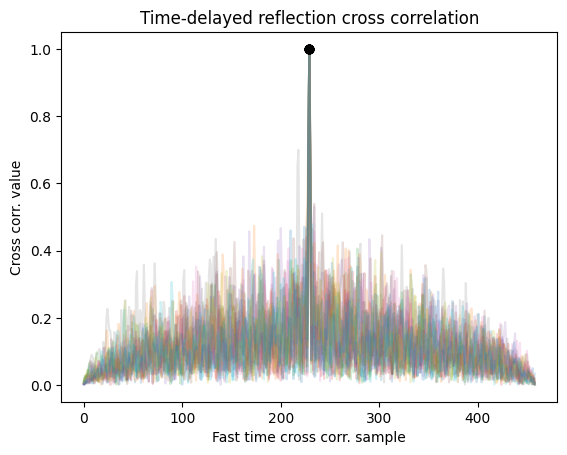

In [10]:
sig = abs(model.corr.T)
sig /= np.max(sig, axis = 0)
peaks = np.argmax(sig, axis = 0)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(peaks, sig[peaks, np.arange(len(model.corr))], c = 'k', zorder =2)

In [11]:
if model.n_reflectors is not None:
    # arb_cross_corr_limit = np.min(np.sort(np.max(sig, axis = 0), axis=0)[-model.n_reflectors:])
    # phase_diff = model.phase_diff_avg_rg[sig.max(axis= 0) >= arb_cross_corr_limit]
    wvc_cell = np.unique(np.where(abs(model.surface) > 0)[0] // len(model.pulse) - 2 )
    wvc_cell = wvc_cell[(wvc_cell>=0) & (wvc_cell< len(model.phase_diff_avg_rg))]
    phase_diff = model.phase_diff_avg_rg[wvc_cell]
    print(f"WVC: {wvc_cell}, \nwith phase diff.: \n{phase_diff}")
else:
    phase_diff = model.phase_diff_avg_rg

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 # c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.1066 rad, which is equal to 7.378 m/s 


In [20]:
# def searchsort_custom(da, bins):
#     return np.searchsorted(bins, da)

# ds["index_digi"] = ds[["fast_time"]].apply(searchsort_custom, bins=bins).fast_time.astype('int32').chunk({'x': chunk_az, 'y': chunk_rg, 'time_slow': chunk_time_slow, 'pulse_time':chunk_pulse_time})

# DASK trial

In [9]:
client.close()

NameError: name 'client' is not defined

In [10]:
import dask
import dask.distributed
client = dask.distributed.Client(n_workers=6)
client

<Client: 'tcp://127.0.0.1:62781' processes=6 threads=12, memory=32.00 GiB>

In [18]:
n_slow_time = 4#len(ds.time_slow)
n_subpulse = len(ds.subpulse)
n_x = np.arange(0, ds.x.shape[0], 100)

n_slow_time, n_subpulse

(4, 2)

In [24]:
ds.isel(time_slow=i, subpulse=j, x=range(n, n+100))

<xarray.Dataset>
Dimensions:                 (x: 100, y: 4000)
Coordinates:
    rg                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    az                      (x, y) float64 dask.array<chunksize=(100, 100), meta=np.ndarray>
    time_slow               float64 0.6353
    subpulse                int64 1
Dimensions without coordinates: x, y
Data variables: (12/13)
    amplitude               (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    scatter_phase           (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    spatial_grid_offset_rg  (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    spatial_grid_offset_az  (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    velocity                (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    reflector               (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...                      ...
    y_sat                   float32 dask.array<chunksize=(), meta=np.ndarray>
    z_sat                   float32 dask.array<chunksize=(), meta=np.ndarray>
    d_ground                (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    R                       (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    travel_time             (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    bin_offset              (x, y) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>

In [25]:
@dask.delayed
def trial(ds, bins):
    
    surface = ds.groupby_bins(group = ds['bin_offset'], bins=bins).sum()
    # surface = da.array(surface.reflector.values)
    # surface = da.where(da.isfinite(surface), surface, 0)
    # surface = surface.reflector.values
    # surface = np.where(np.isfinite(surface), surface, 0)
    return surface

bins = da.array(np.arange(0, len(fast_time_bins)))
surfaces = []
for i in range(n_slow_time):
    for j in range(n_subpulse):
        for n in n_x:
            ds_subset = ds[['bin_offset', 'reflector']].isel(time_slow=i, subpulse=j, x=range(n, n+100))

            surface = trial(ds_subset, bins)ß
            surfaces.append(surface)

In [26]:
surface.compute()

/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 2.21 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-11-03 12:13:01,922 - distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/core.py", line 921, in _handle_comm
    result = await result
             ^^^^^^^^^^^^
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/scheduler.py", line 5518, in add_client
    await self.handle_stream(comm=comm, extra={"client": client})
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/core.py", line 974, in handle_stream
    msgs = await comm.read()
           ^^^^^^^^^^^^^^^^^
  File 

CancelledError: trial-754ba1e6-9cbf-4c14-9fbe-0f3396b4437b

Task exception was never retrieved
future: <Task finished name='Task-82194' coro=<Server._handle_comm() done, defined at /Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/core.py:827> exception=OSError(22, 'Invalid argument')>
Traceback (most recent call last):
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/core.py", line 921, in _handle_comm
    result = await result
             ^^^^^^^^^^^^
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/scheduler.py", line 5518, in add_client
    await self.handle_stream(comm=comm, extra={"client": client})
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/core.py", line 974, in handle_stream
    msgs = await comm.read()
           ^^^^^^^^^^^^^^^^^
  File "/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distribut

In [16]:
a = dask.compute(surfaces)

/Users/opodriscoll/miniconda3/envs/env_stereoid_dask/lib/python3.11/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 226.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [14]:
a

([array([ 7.198236  +5.7586927j, -2.3473735 -5.98138j  ,
         -2.3064904-10.549672j , ...,  0.        +0.j       ,
          0.        +0.j       ,  0.        +0.j       ], dtype=complex64),
  array([ 4.789013 +1.6262945j,  0.993403 +1.077442j ,
         -1.0736656-3.8402288j, ...,  0.       +0.j       ,
          0.       +0.j       ,  0.       +0.j       ], dtype=complex64),
  array([ 1.6045564 -1.8893356j,  0.86521274-1.5026188j,
         -0.04108243-1.3502368j, ...,  0.        +0.j       ,
          0.        +0.j       ,  0.        +0.j       ], dtype=complex64),
  array([2.7436419-0.09375859j, 4.3898726-0.88875306j,
         8.302645 +0.8424065j , ..., 0.       +0.j        ,
         0.       +0.j        , 0.       +0.j        ], dtype=complex64),
  array([-6.896283 -1.1707648j,  7.0998583-3.7738564j,
         -0.5767902+3.8623757j, ...,  0.       +0.j       ,
          0.       +0.j       ,  0.       +0.j       ], dtype=complex64),
  array([-0.48099938-0.13113928j,  0.264147

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.259019 to fit


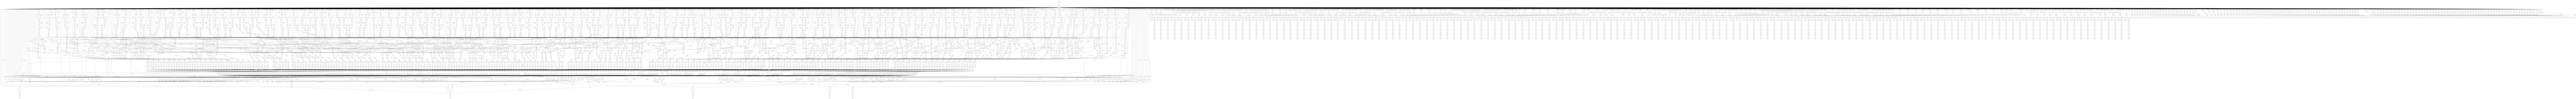

In [48]:
surfaces[0].visualize()

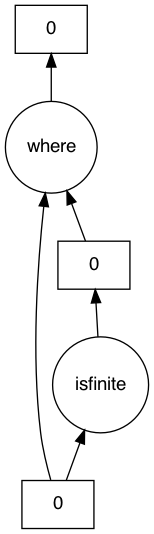

In [40]:
a[0][0].visualize()